### TF regulons

In [ ]:
tf_net = dc.get_collectri(organism="mouse")

### Causal Path

Identify highly-variable and shared peaks

DEA on stratium

In [ ]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


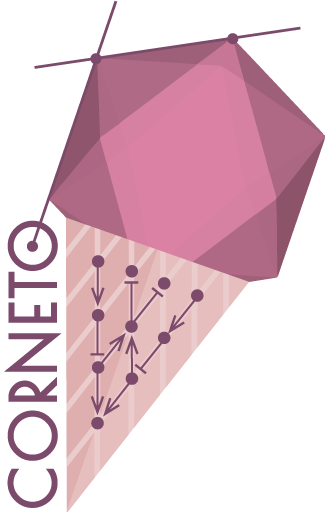

In [ ]:
import corneto as cn
cn.info()

In [ ]:
striatums = {}
for slide in slides:
    rna = mdatas[slide].mod["rna"]
    rna.obs['slide'] = slide
    striatums[slide] = rna[rna.obs['region']=='striatum'].copy()

In [ ]:
ad_striatum = sc.concat(striatums)

In [ ]:
pdata = dc.get_pseudobulk(ad_striatum,
                          sample_col='slide',
                          groups_col='lesion',
                          min_cells=100,
                          min_counts=1000, 
                          mode='sum',
                          layer='counts')

In [ ]:
genes = dc.filter_by_expr(pdata, group='lesion', min_count=5, min_total_count=10)
pdata = pdata[:, genes].copy()

In [ ]:
pdata.obs['lesion'] = pdata.obs['lesion'].astype('category')

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=pdata,
    design_factors='lesion',
    ref_level=['lesion', 'intact'],
    refit_cooks=True,
    n_cpus=8,
)

# Compute LFCs
dds.deseq2()

TypeError: DeseqDataSet.__init__() got an unexpected keyword argument 'n_cpus'

In [ ]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["lesion", 'lesioned', 'intact'], n_cpus=8)
# Compute Wald test
stat_res.summary()
# Shrink LFCs
stat_res.lfc_shrink(coeff='lesion_lesioned_vs_intact')

Running Wald tests...


Log2 fold change & Wald test p-value: lesion lesioned vs intact


... done in 1.49 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,40.054977,0.324066,0.183318,1.767784,0.077097,NaN
0610009L18Rik,34.752800,-0.343826,0.271850,-1.264761,0.205957,NaN
0610010F05Rik,63.720234,-0.074288,0.198453,-0.374336,0.708154,NaN
0610010K14Rik,117.549500,0.014829,0.107907,0.137424,0.890695,0.996121
0610012G03Rik,359.001007,0.105505,0.132166,0.798271,0.424713,0.982416
...,...,...,...,...,...,...
mt-Nd3,28170.337891,-0.197311,0.177487,-1.111693,0.266270,0.910557
mt-Nd4,64427.785156,-0.030874,0.106117,-0.290945,0.771093,0.996121
mt-Nd4l,2777.775391,-0.003283,0.139734,-0.023496,0.981254,0.997164
mt-Nd5,9346.030273,-0.007344,0.139314,-0.052715,0.957959,0.996121


Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: lesion lesioned vs intact


... done in 6.52 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610009B22Rik,40.054977,-0.144270,0.204323,1.767784,0.077097,NaN
0610009L18Rik,34.752800,-0.013736,0.073645,-1.264761,0.205957,NaN
0610010F05Rik,63.720234,-0.005230,0.069922,-0.374336,0.708154,NaN
0610010K14Rik,117.549500,-0.144270,0.204323,0.137424,0.890695,0.996121
0610012G03Rik,359.001007,0.015918,0.069807,0.798271,0.424713,0.982416
...,...,...,...,...,...,...
mt-Nd3,28170.337891,-0.031063,0.084120,-1.111693,0.266270,0.910557
mt-Nd4,64427.785156,-0.002276,0.062444,-0.290945,0.771093,0.996121
mt-Nd4l,2777.775391,-0.000381,0.067427,-0.023496,0.981254,0.997164
mt-Nd5,9346.030273,-0.001193,0.067435,-0.052715,0.957959,0.996121


In [ ]:
# Extract results
results_df = stat_res.results_df

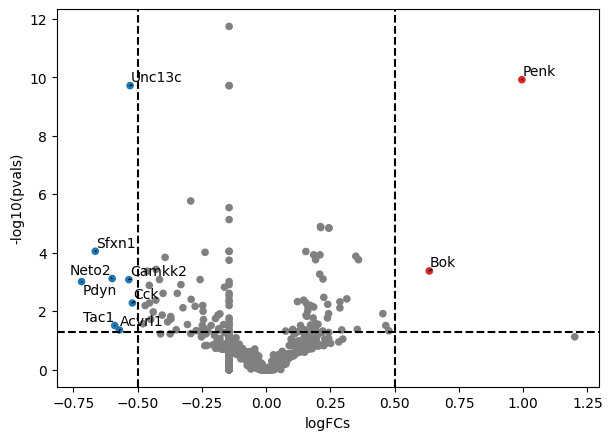

In [ ]:
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20, lFCs_thr=0.5)

In [ ]:
mat = results_df[['stat']].T

In [ ]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=tf_net, min_n=5)
tf_results = pd.DataFrame({'activity': tf_acts.values.flatten(), 'pval': tf_pvals.values.flatten()}, index=tf_acts.columns)

In [ ]:
tf_results['fdr'] = dc.p_adjust_fdr(tf_results['pval'])

In [ ]:
tfs = tf_results[tf_results['fdr'] < 0.1].index

In [ ]:
tf_results[tf_results.index.isin(tfs)]
# Nab2 is intereasting, also Egrs

,activity,pval,fdr
Ar,-2.825209,4.732346e-03,0.083067
Bcl3,-3.139281,1.697504e-03,0.043055
Btg2,2.841332,4.499698e-03,0.083067
Cebpb,-3.755834,1.735365e-04,0.010759
Cebpd,-3.682281,2.321145e-04,0.011126
Crebbp,-3.398496,6.796540e-04,0.025283
Dlx1,2.915636,3.555841e-03,0.073487
Dnmt1,-2.823091,4.763705e-03,0.083067
Egr2,-3.654014,2.592116e-04,0.011126
Egr4,-3.415228,6.392789e-04,0.025283


... storing 'slide' as categorical


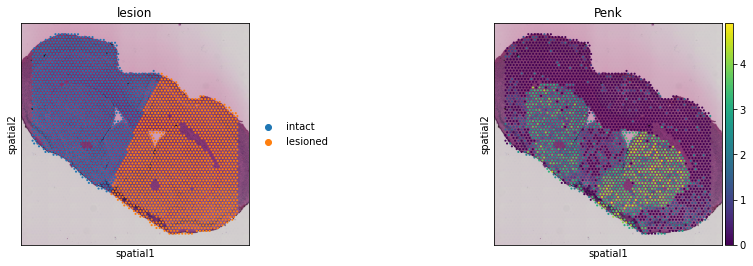

In [ ]:
sc.pl.spatial(rna, color=['lesion', 'Penk'])

Explore TFs

In [ ]:
tfs_of_int = ['Nab2', 'Egr2', 'Egr4', 'Egr1']

In [ ]:
tf_results[tf_results.index.isin(tfs_of_int)]

,activity,pval,fdr
Egr1,-0.359950,0.718891,0.873126
Egr2,-3.654014,0.000259,0.011126
Egr4,-3.415228,0.000639,0.025283
Nab2,3.182244,0.001465,0.038925


In [ ]:
import igraph.layout as layouts

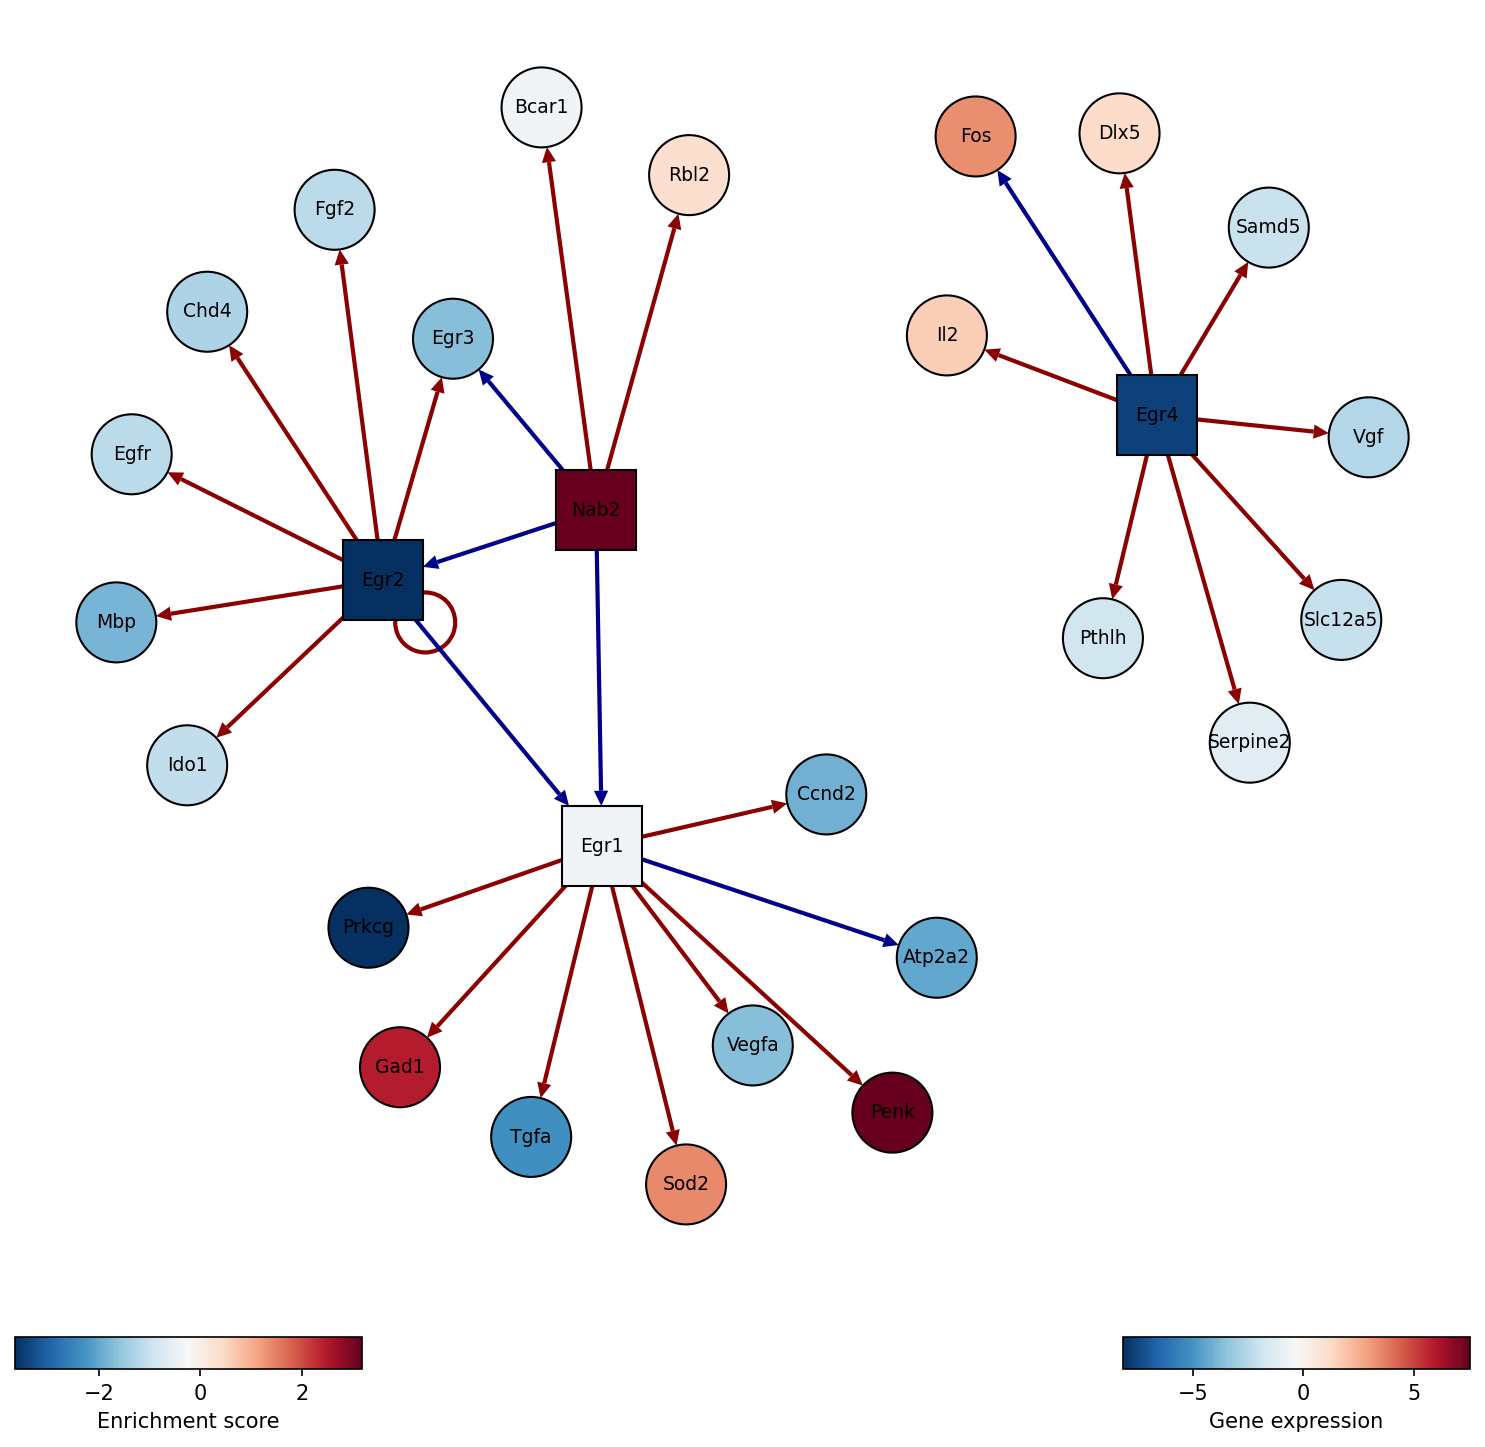

In [ ]:
dc.plot_network(mat, tf_acts[tfs_of_int], tf_net, n_sources=5, n_targets=8, s_cmap='RdBu_r', t_cmap='RdBu_r', label_size=9)

Path

In [ ]:
# remove Egr1 add all the rest
add_targets = tf_net.rename(columns={"weight":'mor'}).drop('PMID', axis=1)

In [ ]:
# bind rows to input_pkn
input_pkn = pd.concat([input_pkn, add_targets], axis=0)

In [ ]:
# exclude Egr1 as it's not deregulated
input_pkn = input_pkn[(input_pkn['source']!='Nab2')]
# add deregulated Nab2 targets
input_pkn.loc[input_pkn.shape[0]] = ['Nab2', -1, 'Egr2']
input_pkn.loc[input_pkn.shape[0]] = ['Nab2', -1, 'Egr4']

In [ ]:
input_pkn[input_pkn['source']=='Nab2']

,source,mor,target
122214,Nab2,-1,Egr2
122215,Nab2,-1,Egr4


In [ ]:
# -1, -1, as we dopamine is downregulated absent in lesion and nab2 is downregulated
input_scores = {"Nab2":1}  # "Nab2":1, "Egr1":-1
output_scores = {"Metab__HMDB0000073_C":-1}

In [ ]:
temp = rna[(rna.obs['region'] == 'striatum') * (rna.obs['lesion'] == 'lesioned')].copy()

node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

In [ ]:
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (39967, 83556)
 - Provided inputs included in the prior network: 1/1
 - Provided outputs included in the network: 0/1
Performing reachability analysis...
done.
 - Selected inputs: 0/1.
 - Selected outputs: 0/0.
 - Final size of the prior graph: (0, 0).


ValueError: None of the output nodes can be reached from the provided input nodes in the PPI network.

In [ ]:
df_res, problem = li.mt.find_causalnet(
    prior_graph,
    input_scores,
    output_scores,
    node_weights,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.1,
    edge_penalty=0.1,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1,
    max_penalty=1,
    missing_penalty=10,
    verbose=True,
    max_seconds=60*5,
    solver='gurobi'
    )


In [ ]:
cn.methods.carnival.visualize_network(df_res)

NameError: name 'df_res' is not defined

Create pretty network

In [ ]:
df_res['target'].replace("Metab__HMDB0000073_c", "Dopamine", inplace=True)
# skip dummy node Gene5465__Ddc, and connect directly Ddc to dopamine
# df_res = df_res[(df_res['target'] != "Ddc") * (df_res['source'] != "Ddc")]
df_res['source'].replace("Gene5465__Ddc", "Ddc", inplace=True)
df_res['target'].replace("Gene5465__Ddc", "Ddc", inplace=True)
df_res = df_res[(df_res['target'] != "Ddc") + (df_res['source'] != "Ddc")]
df_res = df_res[(~df_res['target'].str.contains("_") * ~df_res['source'].str.contains("_"))]

NameError: name 'df_res' is not defined

In [ ]:
cn.methods.carnival.visualize_network(df_res)

NameError: name 'df_res' is not defined

Metabolite to TF

In [ ]:
dopamine_pkn = resource[resource['ligand']=='HMDB0000073']
dopamine_pkn['ligand'] = 'Metab__HMDB0000073_c'

In [ ]:
dopamine_pkn = dopamine_pkn.drop(["Unnamed: 0", "metabolite"], axis=1).rename(columns={"receptor":'target', 'ligand':'source'})


In [ ]:
dopamine_pkn['mor'] = 1

In [ ]:
input_pkn = pd.concat([input_pkn, dopamine_pkn], axis=0)

In [ ]:
# -1, -1, as we dopamine is downregulated absent in lesion and nab2 is downregulated
input_scores = {"Metab__HMDB0000073_c": -1}
output_scores = {"Egr1":-1}  # "Nab2":1, "Egr1":-1

In [ ]:
input_pkn = input_pkn.drop_duplicates()

In [ ]:
temp = rna[(rna.obs['region'] == 'striatum') * (rna.obs['lesion'] == 'lesioned')].copy()

node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

In [ ]:
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (43428, 121340)
 - Provided inputs included in the prior network: 1/1
 - Provided outputs included in the network: 1/1
Performing reachability analysis...
done.
 - Selected inputs: 1/1.
 - Selected outputs: 1/1.
 - Final size of the prior graph: (3238, 33120).


In [ ]:
df_res, problem = li.mt.find_causalnet(
    prior_graph,
    input_scores,
    output_scores,
    node_weights,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.1,
    edge_penalty=0.1,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1,
    max_penalty=1,
    missing_penalty=10,
    verbose=True,
    max_seconds=60*3,
    solver='gurobi'
)

Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: -1
 - (+) input nodes: 0
 - (-) output nodes: -1
 - (+) output nodes: 0
 - abs total (inputs + outputs): 2
Building CORNETO problem...
Solving with gurobi...


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 22 03:59:13 PM: Your problem has 142230 variables, 31 constraints, and 0 parameters.
(CVXPY) Nov 22 03:59:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 03:59:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 03:59:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 03:59:13 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Nov 22 03:59:13 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixS

Set parameter Username


Academic license - for non-commercial use only - expires 2024-07-12


Academic license - for non-commercial use only - expires 2024-07-12


Set parameter QCPDual to value 1


Set parameter QCPDual to value 1


Set parameter TimeLimit to value 180


Set parameter TimeLimit to value 180


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)


CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


Optimize a model with 562433 rows, 142230 columns and 1059310 nonzeros


Optimize a model with 562433 rows, 142230 columns and 1059310 nonzeros


Model fingerprint: 0x6ebc4c40


Model fingerprint: 0x6ebc4c40


Variable types: 36368 continuous, 105862 integer (105862 binary)


Variable types: 36368 continuous, 105862 integer (105862 binary)


Coefficient statistics:


Coefficient statistics:


  Matrix range     [1e-03, 3e+03]


  Matrix range     [1e-03, 3e+03]


  Objective range  [1e-01, 1e+01]


  Objective range  [1e-01, 1e+01]


  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e-03, 3e+03]


  RHS range        [1e-03, 3e+03]


Presolve removed 357200 rows and 4375 columns


Presolve removed 357200 rows and 4375 columns


Presolve time: 4.53s


Presolve time: 4.53s


Presolved: 205233 rows, 137855 columns, 628784 nonzeros


Presolved: 205233 rows, 137855 columns, 628784 nonzeros


Variable types: 35748 continuous, 102107 integer (102107 binary)


Variable types: 35748 continuous, 102107 integer (102107 binary)


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


Showing barrier log only...


Root barrier log...


Root barrier log...


Ordering time: 10.59s


Ordering time: 10.59s


Elapsed ordering time = 11s


Elapsed ordering time = 11s


Ordering time: 14.78s


Ordering time: 14.78s


Barrier performed 0 iterations in 23.15 seconds (7.64 work units)


Barrier performed 0 iterations in 23.15 seconds (7.64 work units)


Barrier solve interrupted - model solved by another algorithm


Barrier solve interrupted - model solved by another algorithm


Concurrent spin time: 7.79s (can be avoided by choosing Method=3)


Concurrent spin time: 7.79s (can be avoided by choosing Method=3)


Solved with primal simplex


Solved with primal simplex


Root simplex log...


Root simplex log...


Iteration    Objective       Primal Inf.    Dual Inf.      Time


Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7196   -1.0999668e+00   0.000000e+00   0.000000e+00     23s


    7196   -1.0999668e+00   0.000000e+00   0.000000e+00     23s


Extra simplex iterations after uncrush: 2


Extra simplex iterations after uncrush: 2


Root relaxation: objective -1.099967e+00, 7196 iterations, 17.00 seconds (3.57 work units)


Root relaxation: objective -1.099967e+00, 7196 iterations, 17.00 seconds (3.57 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0   -1.09997    0   23          -   -1.09997      -     -   24s


     0     0   -1.09997    0   23          -   -1.09997      -     -   24s


H    0     0                       9.4000229   -1.09997   112%     -   27s


H    0     0                       9.4000229   -1.09997   112%     -   27s


     0     0   -0.99997    0   12    9.40002   -0.99997   111%     -   30s


     0     0   -0.99997    0   12    9.40002   -0.99997   111%     -   30s


H    0     0                       9.2000229   -0.99997   111%     -   48s


H    0     0                       9.2000229   -0.99997   111%     -   48s


     0     0   -0.99995    0   43    9.20002   -0.99995   111%     -   60s


     0     0   -0.99995    0   43    9.20002   -0.99995   111%     -   60s


     0     0   -0.99995    0   43    9.20002   -0.99995   111%     -   60s


     0     0   -0.99995    0   43    9.20002   -0.99995   111%     -   60s


     0     0   -0.98885    0   43    9.20002   -0.98885   111%     -   71s


     0     0   -0.98885    0   43    9.20002   -0.98885   111%     -   71s


     0     0   -0.95996    0   28    9.20002   -0.95996   110%     -   79s


     0     0   -0.95996    0   28    9.20002   -0.95996   110%     -   79s


     0     0   -0.94997    0   67    9.20002   -0.94997   110%     -  101s


     0     0   -0.94997    0   67    9.20002   -0.94997   110%     -  101s


     0     0   -0.94282    0   65    9.20002   -0.94282   110%     -  111s


     0     0   -0.94282    0   65    9.20002   -0.94282   110%     -  111s


     0     0   -0.93330    0   70    9.20002   -0.93330   110%     -  114s


     0     0   -0.93330    0   70    9.20002   -0.93330   110%     -  114s


     0     0   -0.92966    0  101    9.20002   -0.92966   110%     -  124s


     0     0   -0.92966    0  101    9.20002   -0.92966   110%     -  124s


     0     0   -0.92497    0   90    9.20002   -0.92497   110%     -  142s


     0     0   -0.92497    0   90    9.20002   -0.92497   110%     -  142s


     0     0   -0.92330    0   92    9.20002   -0.92330   110%     -  147s


     0     0   -0.92330    0   92    9.20002   -0.92330   110%     -  147s


     0     0   -0.92330    0   94    9.20002   -0.92330   110%     -  149s


     0     0   -0.92330    0   94    9.20002   -0.92330   110%     -  149s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  153s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  153s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  166s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  166s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  169s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  169s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  171s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  171s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  180s


     0     0   -0.91858    0   65    9.20002   -0.91858   110%     -  180s


Cutting planes:


Cutting planes:


  Cover: 14


  Cover: 14


  Implied bound: 14


  Implied bound: 14


  MIR: 2


  MIR: 2


  Flow cover: 10


  Flow cover: 10


  Zero half: 6


  Zero half: 6


  Network: 2


  Network: 2


  Relax-and-lift: 1


  Relax-and-lift: 1


Explored 1 nodes (60965 simplex iterations) in 180.03 seconds (127.49 work units)


Explored 1 nodes (60965 simplex iterations) in 180.03 seconds (127.49 work units)


Thread count was 12 (of 12 available processors)


Thread count was 12 (of 12 available processors)


Solution count 2: 9.20002 9.40002 


Solution count 2: 9.20002 9.40002 


Time limit reached


Time limit reached


Best objective 9.200022864915e+00, best bound -9.185761587782e-01, gap 109.9845%


Best objective 9.200022864915e+00, best bound -9.185761587782e-01, gap 109.9845%


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 22 04:02:23 PM: Problem status: user_limit
(CVXPY) Nov 22 04:02:23 PM: Optimal value: 1.120e+01
(CVXPY) Nov 22 04:02:23 PM: Compilation took 5.431e+00 seconds
(CVXPY) Nov 22 04:02:23 PM: Solver (including time spent in interface) took 1.844e+02 seconds


Done.
Solution summary:
 - Loss (unfitted inputs/output): [0.]
 - Edge penalty error: 10.0
 - Node penalty error: 10.200022864915407


In [ ]:
df_res['target'].replace("Metab__HMDB0000073_c", "Dopamine", inplace=True)
# skip dummy node Gene5465__Ddc, and connect directly Ddc to dopamine
# df_res = df_res[(df_res['target'] != "Ddc") * (df_res['source'] != "Ddc")]
df_res['source'].replace("Gene5465__Ddc", "Ddc", inplace=True)
df_res['target'].replace("Gene5465__Ddc", "Ddc", inplace=True)
df_res = df_res[(df_res['target'] != "Ddc") + (df_res['source'] != "Ddc")]
df_res = df_res[(~df_res['target'].str.contains("_") * ~df_res['source'].str.contains("_"))]

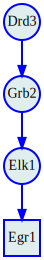

In [ ]:
cn.methods.carnival.visualize_network(df_res)

In [ ]:
import omnipath as op

In [ ]:
kegg = op.requests.Annotations.get(resources=["KEGG-PC"], entity_types=['protein'])
kegg = kegg[["value", "genesymbol"]].rename({"value": "source", "genesymbol": "target"}, axis=1)
kegg = kegg[["source", "target"]].drop_duplicates()
kegg['target'] = kegg['target'].str.title()

In [ ]:
interaction_list = {}
target_list = {}

for slide in slides:
    mdata = mdatas[slide]
    
    msi = mdata.mod["msi"]
    msi = msi[:, hvg].copy()
    sc.pp.scale(msi, max_value=5)
    msi.X[msi.X < 0] = 0
    
    # distances of metabolties to RNA
    reference = mdata.mod["msi"].obsm["spatial"]
    
    deconv = mdata.mod["deconv"]
    li.ut.spatial_neighbors(deconv, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
    
    rna = mdata.mod["rna"]
    li.ut.spatial_neighbors(rna, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
    
    dc.run_ulm(rna, net = kegg, use_raw=False, weight=None)
    path = li.ut.obsm_to_adata(rna, "ulm_estimate")
    
    # dc.run_ulm(rna, net = tf_subset, use_raw=False, weight=None, min_n=3)
    # tf = li.ut.obsm_to_adata(rna, "ulm_estimate")
    rec = rna[:, receptors[np.isin(receptors, rna.var.index)]].copy()

    # misty
    mdata.update_obs()
    
    misty = li.mt.MistyData({"intra": msi, "ct": deconv, "path":path}, enforce_obs=False, obs=mdata.obs)
    misty(model="linear", verbose=True, bypass_intra=True)
    
    interaction_list[slide] = misty.uns['interactions'].copy()
    target_list[slide] = misty.uns['target_metrics'].copy()

In [ ]:
(
    li.pl.interactions(misty, aggregate_fun="median", view='path', top_n=50, figure_size=(10, 10)) + 
    # limits -10 to 10
    p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=(-15, 15)) +
    p9.theme_minimal(base_size=20) +
    p9.theme(figure_size=(10, 10)) +
    # rotate x
    p9.theme(axis_text_x=p9.element_text(angle=90))
    
 )

In [ ]:
li.pl.contributions(misty, aggregate_fun='mean', filter_fun= lambda x: bool((x['gain_R2'] > 0.3)))